# Chapter 3: Exercise 10

**Import packages**

In [92]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from ISLP.models import (ModelSpec as MS, summarize)

**Load Carseats data set**

In [2]:
os.chdir('C:/Users/carma/Documents/Python Projects/islp/Introduction-to-Statistical-Learning-with-Python/Datasets')
Carseats = pd.read_csv('Carseat.csv')

### (a) Multiple regression model to predict Sales using Price, Urban, and US

**Convert object dtypes to categorical**

In [3]:
Carseats = Carseats.astype({'ShelveLoc': 'category', 'Urban': 'category', 'US': 'category'})

In [4]:
Carseats.dtypes

Sales           float64
CompPrice         int64
Income            int64
Advertising       int64
Population        int64
Price             int64
ShelveLoc      category
Age               int64
Education         int64
Urban          category
US             category
dtype: object

**Fit the model**

In [5]:
design = MS(['Price', 'Urban', 'US'])
X = design.fit_transform(Carseats)
y = Carseats['Sales']

In [6]:
model = sm.OLS(y, X)
results = model.fit()

In [7]:
summarize(results)

,coef,std err,t,P>|t|
intercept,13.0435,0.651,20.036,0.000
Price,-0.0545,0.005,-10.389,0.000
Urban[Yes],-0.0219,0.272,-0.081,0.936
US[Yes],1.2006,0.259,4.635,0.000


### (b) Interpretation of each coefficient in the model

- **intercept:** 13.0435 is the average number of unit sales (in thousands) when price is &dollar;0, location is rural, and location is not in the US.
- **Price:** An increase in price of $1 reduces the number of units sold by -0.0545 (in thousands).
- **Urban[Yes]:** Stores in urban locations sell 0.0219 *fewer* units (in thousands) than average. However we note the p-value is very high indicating there is no statistical evidence of a difference in average units sold between urban and rural stores.
- **US[Yes]:** Stores in the US sell 1.2006 more units (in thousands) than average.

### (c) Linear regression equation

$$\hat{y} = 13.0435 - 0.0545 X_1 - 0.0219 X_2 + 1.2006 X_3$$

 Where $X_1 = Price$, $X_2 = Urban[Yes]$, $X_3 = US[Yes]$

$X_2$ is 0 if rural, 1 if urban.
$X_3$ is 0 if store is not in US, 1 if is in US.

### (d) Predictors for which we can reject the null hypothesis $H_0: \beta_j = 0$

We can reject the null hypothesis for the predictors Price and US[Yes]. This implies that their effect on sales is statistically significant.

### (e) Fit a smaller model using only predictors for which there is evidence of association with the outcome, sales

In [71]:
design = MS(['Price', 'US'])
X = design.fit_transform(Carseats)
y = Carseats['Sales']

In [72]:
model = sm.OLS(y, X)
results1 = model.fit()

In [73]:
summarize(results1)

,coef,std err,t,P>|t|
intercept,13.0308,0.631,20.652,0.0
Price,-0.0545,0.005,-10.416,0.0
US[Yes],1.1996,0.258,4.641,0.0


### (f) Compare the fit of the two models

In [74]:
sm.stats.anova_lm(results, results1)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,396.0,2420.834671,0.0,NaN,NaN,NaN
1,397.0,2420.874462,-1.0,-0.03979,0.006525,NaN


Dropping the predictor Urban[Yes] does not seem to change the fit of the model to the data. Let us compare residual plots.

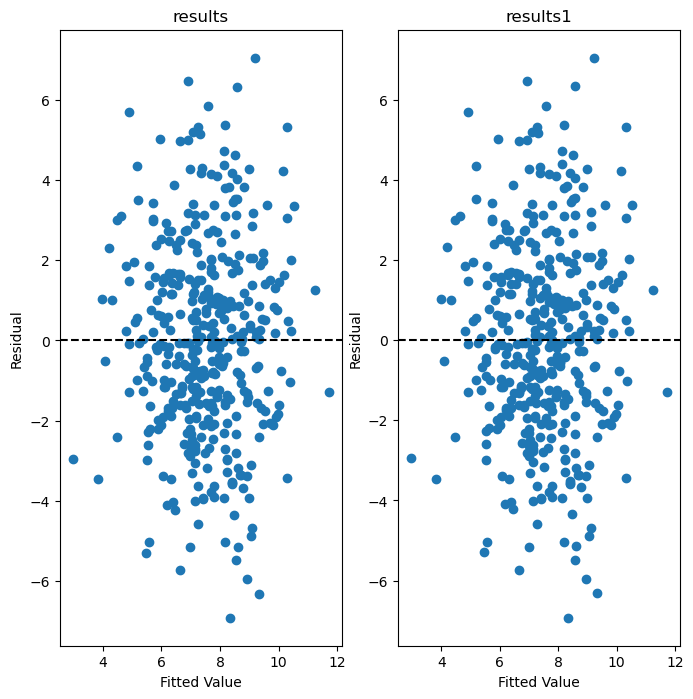

In [91]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(8,8))
ax[0].scatter(x=results.fittedvalues, y=results.resid)
ax[0].set_title('results')
ax[1].scatter(x=results1.fittedvalues, y=results1.resid)
ax[1].set_title('results1')
for ax in ax.flat:
    ax.set(xlabel='Fitted Value', ylabel='Residual')
    ax.axhline(0, c='k', ls='--')
plt.show()

In [78]:
results.fittedvalues - results1.fittedvalues

0     -0.006056
1     -0.006751
2     -0.006808
3     -0.006488
4     -0.006836
         ...   
395   -0.005906
396    0.015860
397   -0.005324
398   -0.006526
399   -0.006056
Length: 400, dtype: float64

We see there is very little difference in the residual plots, and also the difference between the fitted values.

### (g) 95% confidence interval for the coefficients

In [84]:
results1.conf_int()

,0,1
intercept,11.79032,14.271265
Price,-0.06476,-0.044195
US[Yes],0.69152,1.707766


### (h) Outliers and high leverage observations

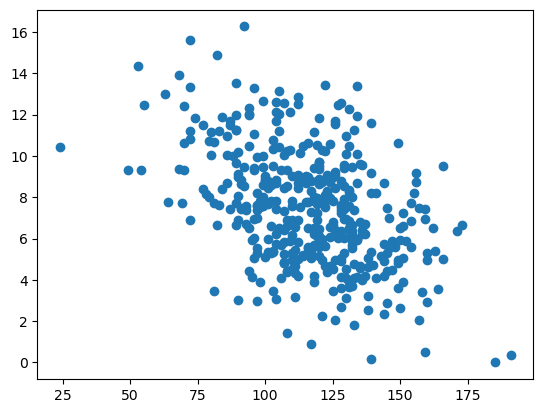

In [88]:
plt.scatter(Carseats['Price'], y)

There appears to be a linear relationship between price and sales. This supports what we see in the residual plot above where there appears to be no discernible pattern indicating no non-linearity in the data. We see a possible high leverage observation on the far left.

In [93]:
infl = results1.get_influence()
stu_res = infl.get_resid_studentized_external()

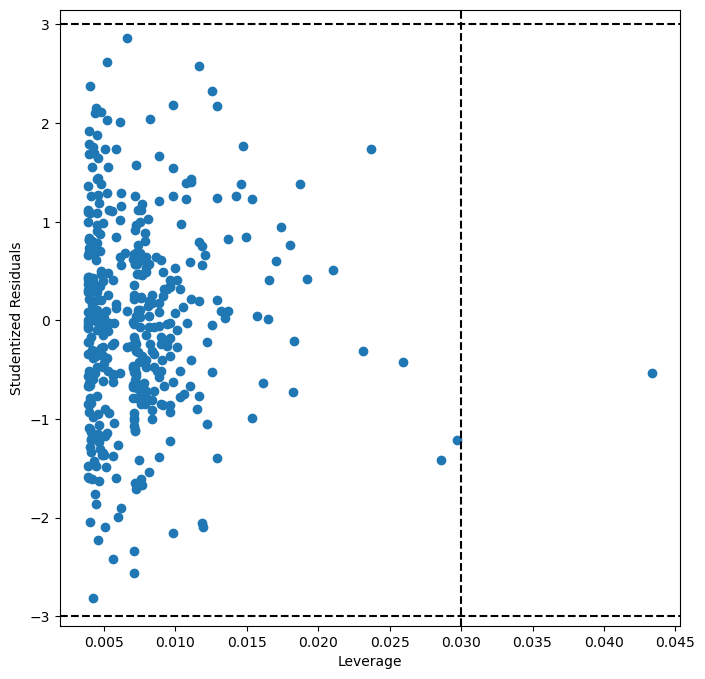

In [94]:
fig, ax = plt.subplots(figsize=(8,8))
plt.scatter(infl.hat_matrix_diag, stu_res)
plt.xlabel('Leverage')
plt.ylabel('Studentized Residuals')
plt.axhline(-3, c='k', ls='--')
plt.axhline(3, c='k', ls='--')
plt.axvline(np.average(infl.hat_matrix_diag)*4, c='k', ls='--')

There are no observations whose studentized residuals are greater than three in absolute value. Thus there is no evidence of outliers in our model. We do see one observation which has leverage greater than four times the average leverage, leading us to conclude that this is a high leverage observation and may wish to exclude it from our model.

In [96]:
enum = [x for x in enumerate(infl.hat_matrix_diag)]

In [99]:
dtype = [('index', int), ('leverage', float)]
a = np.array(enum, dtype=dtype)
np.sort(a, order='leverage')[-1:]

array([(42, 0.04333766)], dtype=[('index', '<i4'), ('leverage', '<f8')])

In [101]:
X.iloc[[42]]

,intercept,Price,US[Yes]
42,1.0,24,0.0


In [106]:
np.argmin(X['Price'])

42

We see observation 42 with Price = 24 is indeed a high leverage point. This observation has the minimum Price value of all observations in our dataset.